# Jupyter-notebook to visualize the workings of edge models

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
import sys
from matplotlib import animation
from IPython.display import HTML

# Let's read in params and functions from experiments:
sys.path.append('../simulations')
import parameters as params
from functions import create_drift, apply_drift

# Helper functions

In [2]:
# Create an unoriented 2d Gaussian filter
def define_gauss(x, y, sigma):
    gauss = 1. / (np.sqrt(2.*np.pi) * sigma) * np.exp(-(x**2. + y**2.) / (2.*sigma**2.))
    return gauss


# Create an unoriented 2d Difference-of-Gaussians filter
def define_dog(x, y, sigma_c, sigma_s):
    gauss_c = define_gauss(x, y, sigma_c)
    gauss_s = define_gauss(x, y, sigma_s)

    # Normalize each filter by its total sum
    gauss_c = gauss_c / gauss_c.sum()
    gauss_s = gauss_s / gauss_s.sum()

    dog = gauss_c - gauss_s
    return dog


# Create Gaussian derivative filter in x-direction
def define_gaussx(x, y, sigma):
    gauss_x = -x / (2.*np.pi*sigma**4.) * np.exp(-(x**2.+y**2.)/ (2.*sigma**2.))
    return gauss_x / gauss_x.max()


# Calculate zero-crossings:
def zero_crossings(image, thresh):
    image[np.abs(image)<thresh] = 0.
    zh_image = np.zeros(image.shape)
    zv_image = np.zeros(image.shape)

    for i in range(0,image.shape[0]-1):
        for j in range(0,image.shape[1]-1):
            if image[i][j]==0.:
                if (image[i-1][j]<0.) and (image[i+1][j]>0.):
                    zh_image[i,j] = 1
                elif (image[i-1][j]>0.) and (image[i+1][j]<0.):
                    zh_image[i,j] = 1
                elif (image[i][j-1]<0.) and (image[i][j+1]>0.):
                    zv_image[i,j] = 1
                elif (image[i][j-1]>0.) and (image[i][j+1]<0.):
                    zv_image[i,j] = 1
            elif image[i][j]<0.:
                if image[i+1][j]>0.:
                    zh_image[i,j] = 1
                elif image[i][j+1]>0.:
                    zv_image[i,j] = 1
            elif image[i][j]>0.:
                if image[i+1][j]<0.:
                    zh_image[i,j] = 1
                elif image[i][j+1]<0.:
                    zv_image[i,j] = 1
    return zh_image, zv_image


# Calculate directional peaks:
def peaks(image, thresh, axis):
    image[np.abs(image)<thresh] = 0.
    p_image = np.zeros(image.shape)
    
    for i in range(0,image.shape[0]-1):
        for j in range(0,image.shape[1]-1):
            if image[i][j]>0.:
                if image[i+1][j]<image[i][j] and image[i-1][j]<image[i][j] and axis==1:
                    p_image[i,j] = 1
                elif image[i][j+1]<image[i][j] and image[i][j-1]<image[i][j] and axis==0:
                    p_image[i,j] = 1
    return p_image


# Helper function for displaying videos:
def show_video(vid_arr, cmap='gray'):
    %matplotlib inline
    fig = plt.figure(figsize=(8,8))
    im = plt.imshow(vid_arr[:,:,0], cmap=cmap, vmin=0, vmax=1)
    plt.axis('off')
    plt.close()

    def init():
        im.set_data(vid_arr[:,:,0])

    def animate(i):
        im.set_data(vid_arr[:,:,i])
        return im

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=vid_arr.shape[2], interval=50)
    plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
    return anim

# 1. Example stimulus

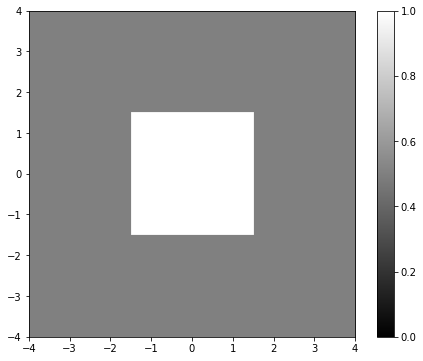

In [3]:
# Spatial resolution for simulations (pixels per degree).
ppd = params.ppd

# Visual extent of full stimulus
vextent = [-4., 4., -4., 4.]  # in deg
ssize = int((vextent[1]-vextent[0])*ppd)
x = np.linspace(vextent[0], vextent[1], ssize)
xx, yy = np.meshgrid(x, x)

# Create stimulus that consists of white square on black background
v = int(1.5 * ppd)
stimulus = np.zeros([ssize, ssize]) + 0.5
stimulus[int(ssize/2)-v:int(ssize/2)+v, int(ssize/2)-v:int(ssize/2)+v] = 1.

plt.figure(figsize=(8, 6))
plt.imshow(stimulus, cmap='gray', extent=vextent, vmin=0., vmax=1.), plt.colorbar()
plt.show()

# 2. Workings of human edge models

We differentiate two types of classical human edge models:

A. Unoriented filters + directional features (either blurring + directional derivative or differential filter + zero-crossings -> equivalent)

B. Oriented filters (+ directional features) (e.g Gaussian derivative filter + peaks)

## 2A) Unoriented filters + directional features

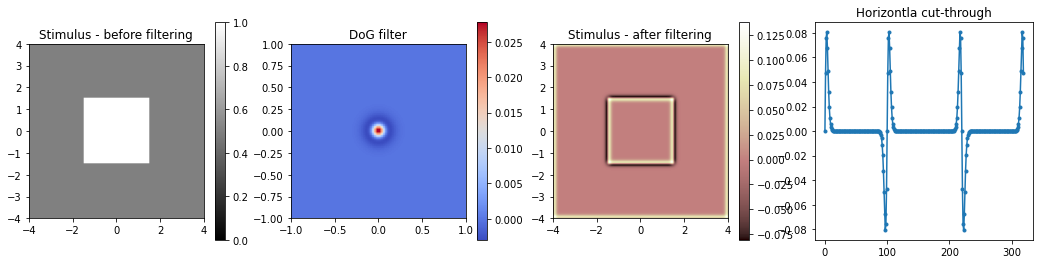

In [4]:
# Step 1: Create and use unoriented filter (here: DoG filter):
# Create DoG-filter
sigma = 0.05
dog = define_dog(xx, yy, sigma, sigma*2.)

# Filter the stimulus
stimulus_filt = fftconvolve(stimulus, dog, 'same')

# Plot results
plt.figure(figsize=(18, 4))
plt.subplot(141)
plt.imshow(stimulus, cmap='gray', extent=vextent, vmin=0., vmax=1.), plt.colorbar()
plt.title('Stimulus - before filtering')

plt.subplot(142)
plt.imshow(dog, cmap='coolwarm', extent=vextent), plt.colorbar()
plt.xlim(-1., 1.), plt.ylim(-1., 1.)
plt.title('DoG filter')

plt.subplot(143)
plt.imshow(stimulus_filt, cmap='pink', extent=vextent), plt.colorbar()
plt.title('Stimulus - after filtering')

plt.subplot(144)
plt.plot(stimulus_filt[int(ssize/2), :], '.-')
plt.title('Horizontla cut-through')
#plt.savefig('type1_1.png', dpi=300)
plt.show()

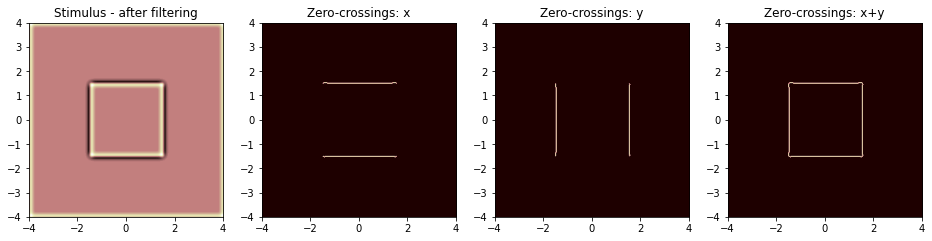

In [5]:
# Step 2: Compute directional features (here: zero-crossings)
# Calculate zero-crossings in x- and y-direction
zx, zy = zero_crossings(stimulus_filt, thresh=0.01)

# Plot results
plt.figure(figsize=(16, 6))
plt.subplot(141)
plt.imshow(stimulus_filt, cmap='pink', extent=vextent)
plt.title('Stimulus - after filtering')

plt.subplot(142)
plt.imshow(zx, cmap='pink', extent=vextent)
plt.title('Zero-crossings: x')

plt.subplot(143)
plt.imshow(zy, cmap='pink', extent=vextent)
plt.title('Zero-crossings: y')

plt.subplot(144)
plt.imshow(zx+zy, cmap='pink', extent=vextent)
plt.title('Zero-crossings: x+y')
#plt.savefig('type1_2.png', dpi=300)
plt.show()

## 2B) Oriented filters (+ directional features)

Different than before, we do not require the computation of additional features.
However, they are often computed to get sharper edges.

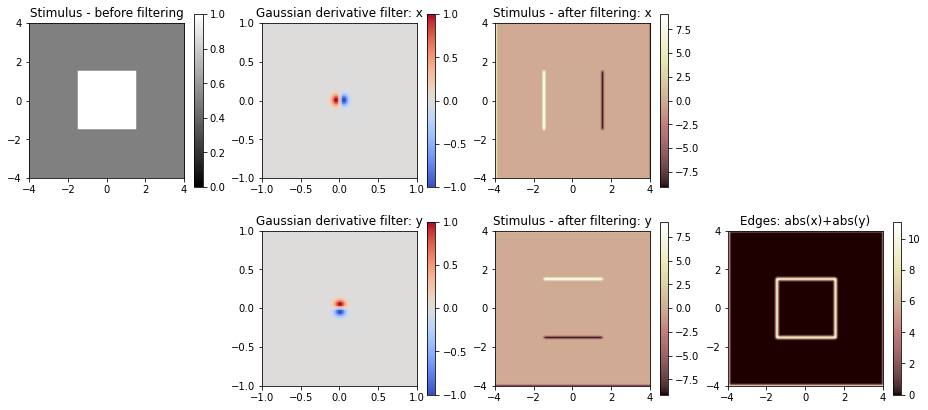

In [6]:
# Step 1: Create and use oriented filter (here: Gaussian derivative filter):
# Gaussian derivative:
sigma = 0.05
gauss_x = define_gaussx(xx, yy, sigma)
gauss_y = np.transpose(gauss_x)

# Filter the stimulus
stimulus_filtx = fftconvolve(stimulus, gauss_x, 'same')
stimulus_filty = fftconvolve(stimulus, gauss_y, 'same')
edges = np.abs(stimulus_filtx)+np.abs(stimulus_filty)

# Plot results
plt.figure(figsize=(16, 7))
plt.subplot(241)
plt.imshow(stimulus, cmap='gray', extent=vextent, vmin=0., vmax=1.), plt.colorbar()
plt.title('Stimulus - before filtering')

plt.subplot(242)
plt.imshow(gauss_x, cmap='coolwarm', extent=vextent), plt.colorbar()
plt.xlim(-1., 1.), plt.ylim(-1., 1.)
plt.title('Gaussian derivative filter: x')

plt.subplot(243)
plt.imshow(stimulus_filtx, cmap='pink', extent=vextent), plt.colorbar()
plt.title('Stimulus - after filtering: x')

plt.subplot(246)
plt.imshow(gauss_y, cmap='coolwarm', extent=vextent), plt.colorbar()
plt.xlim(-1., 1.), plt.ylim(-1., 1.)
plt.title('Gaussian derivative filter: y')

plt.subplot(247)
plt.imshow(stimulus_filty, cmap='pink', extent=vextent), plt.colorbar()
plt.title('Stimulus - after filtering: y')

plt.subplot(248)
plt.imshow(edges, cmap='pink', extent=vextent), plt.colorbar()
plt.title('Edges: abs(x)+abs(y)')
#plt.savefig('type2_1.png', dpi=300)
plt.show()

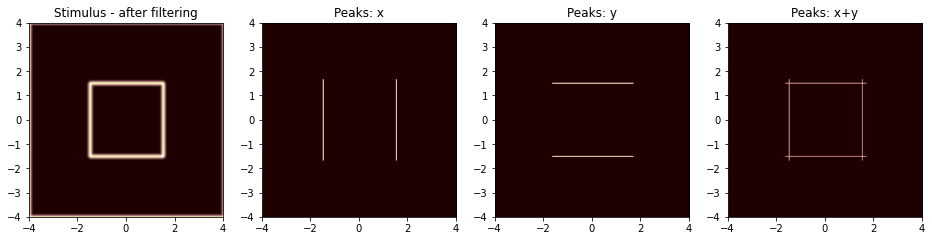

In [7]:
# Step 2 (optional): Compute directional features (here: peaks)
# Calculate peaks in x- and y-direction
px = peaks(np.abs(stimulus_filtx), thresh=0.01, axis=0)
py = peaks(np.abs(stimulus_filty), thresh=0.01, axis=1)

# Plot results
plt.figure(figsize=(16, 6))
plt.subplot(141)
plt.imshow(edges, cmap='pink', extent=vextent)
plt.title('Stimulus - after filtering')

plt.subplot(142)
plt.imshow(px, cmap='pink', extent=vextent)
plt.title('Peaks: x')

plt.subplot(143)
plt.imshow(py, cmap='pink', extent=vextent)
plt.title('Peaks: y')

plt.subplot(144)
plt.imshow(px+py, cmap='pink', extent=vextent)
plt.title('Peaks: x+y')
#plt.savefig('type2_2.png', dpi=300)
plt.show()

# 3. Alternative: Active-sampling + (Spatio-)temporal filtering

In [8]:
# Parameters
# Total simulated fixation time in s
T = params.T

# Drift sampling frequency in Hz / Temporal resolution
pps = params.pps

In [16]:
# Create fake "drift": Wiggle image 1px left-right + up-down
drift = np.zeros([2, int(T*pps+1)])
drift[0, :] = np.random.randint(-1, 1, int(T*pps+1))
drift[1, :] = np.random.randint(-1, 1, int(T*pps+1))

In [17]:
# Apply drift to stimulus to create dynamic video:
stimulus_video = apply_drift(stimulus, drift, back_lum=stimulus.mean())

In [18]:
# Display actively-sampled input video:
anim = show_video(stimulus_video)
HTML(anim.to_html5_video())

In [19]:
# Get three trajectories:
# 1. Homogeneous surface gray
tra1 = stimulus_video[int(ssize/4), int(ssize/4), :]

# 2. Homogeneous surface gray
tra2 = stimulus_video[int(ssize/2), int(ssize/2), :]

# 3. Close to edge
tra3 = stimulus_video[int(ssize/2), int(ssize/2)+v, :]

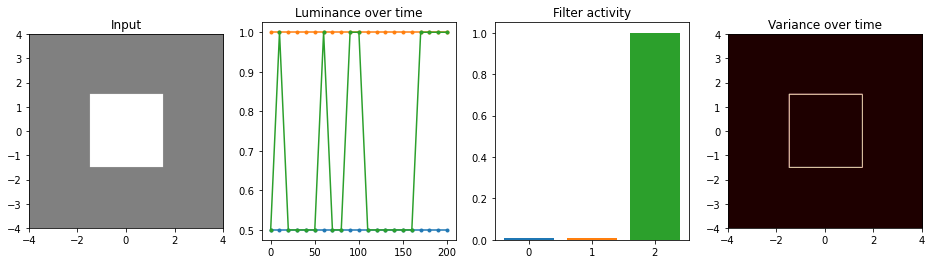

In [24]:
time = np.linspace(0., T, int(T*pps+1)) * 1000.

plt.figure(figsize=(16, 4))
plt.subplot(141)
plt.imshow(stimulus, cmap='gray', extent=vextent, vmin=0., vmax=1.), plt.title('Input')
plt.subplot(142)
plt.plot(time, tra1, '.-')
plt.plot(time, tra2, '.-')
plt.plot(time, tra3, '.-')
plt.title('Luminance over time')
plt.subplot(143)
plt.bar(0, 0.01)
plt.bar(1, 0.01)
plt.bar(2, 1)
plt.title('Filter activity')
plt.subplot(144)
plt.imshow(stimulus_video.var(2), cmap='pink', extent=vextent)  # calculate edges as variance over time
plt.title('Variance over time')
#plt.savefig('our_model.png', dpi=300)
plt.show()